In [77]:
import ee
import geemap
import pandas as pd
import numpy as np
import os
import geopandas as gpd

In [78]:
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [79]:
os.chdir('/Users/najah/work/internships/meghna//LT05_L1TP_145044_20100428_20161016_01_T1')

In [43]:
## adding points from gee
# points = ee.FeatureCollection("projects/fire-ashoka/assets/145044_20100428_500points1")

# Map.addLayer(points, {'color':'red'}, '500points')

In [80]:
## adding points from local machine
Map = geemap.Map()
points_shp = './145044_20100428_roi/145044_20100428_500points.random_points2/145044_20100428_500points.shp'
points = geemap.shp_to_ee(points_shp)
Map.addLayer(   points, {'color':'red'}, '500points')
Map.centerObject(points,8)
Map
 

Map(center=[23.101347181130787, 78.0196924881727], controls=(WidgetControl(options=['position', 'transparent_b…

In [119]:
## distribution of points



gpd.read_file(points_shp)['class'].value_counts()

11    149
5     111
1      56
13     50
4      43
15     35
2      22
16     15
17     10
8       9
Name: class, dtype: int64

In [120]:
## need to rewrite the classes

cats = pd.Series(['Forest', 'Forest Fire', 'Forest Active Fire', 'Ag', "Ag Fire", 'Ag Active Fire', 'Shadow',
                  'Water', 'Cloud', ,' Others',  'Unknown'
                 ])

numbers = pd.Series(list(range(1,14)))
d = {'class': numbers,'class_label': cats}
labels =pd.DataFrame(d)
labels

SyntaxError: invalid syntax (1080671861.py, line 4)

In [81]:
## adding the landsat image

image = ee.Image('LANDSAT/LT05/C01/T1_TOA/LT05_145044_20100428') \
            .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7'])

Map.centerObject(image)

rgbVis = {
  'min':0,
  'max' :0.4,
  'bands' : ['B5', 'B4', 'B3'],
  'gamma' : 1.2
}

Map.addLayer(image, rgbVis, 'original')
Map

Map(bottom=28744.0, center=[23.101347181130787, 78.0196924881727], controls=(WidgetControl(options=['position'…

In [82]:
# Calculate Slope and Elevation
elevation_raster = ee.Image('USGS/SRTMGL1_003')

elev = elevation_raster.select('elevation').rename('elev')
slope = ee.Terrain.slope(elevation_raster.select('elevation')).rename('slope')

##image meta data

image = image.addBands(elev).addBands(slope)



In [ ]:
# Creates a shadow band, with output 1 where pixels are illumunated and 0
# where they are shadowed. Takes as input an elevation band, azimuth and
# zenith of the light source in degrees, a neighborhood size, and whether or
# not to apply hysteresis when a shadow appears. Currently, this algorithm
# only works for Mercator projections, in which light rays are parallel.

# def getShadow(image):
#     azimuth = image.get('SUN_AZIMUTH').getInfo(),
#     elevation = image.get('SUN_ELEVATION').getInfo(),
#     zenith = ee.Number(90).subtract(ee.Number(elevation)).getInfo(),
#     shadow = ee.Terrain.hillShadow(image, azimuth, zenith),
#     return image.addBands(shadow)

# image  = getShadow(image)

In [83]:
## temp fix
azimuth = image.get('SUN_AZIMUTH').getInfo()
elevation = image.get('SUN_ELEVATION').getInfo()
zenith = ee.Number(90).subtract(ee.Number(elevation)).getInfo()
shadow = ee.Terrain.hillShadow(image, azimuth, zenith)
image = image.addBands(shadow)

#### indices

In [84]:
## creating the indices
def addIndices(image):

  ndvi = image.normalizedDifference(['B4', 'B3']).rename('ndvi'),

  ndmi = image.normalizedDifference(['B4', 'B5']).rename('ndmi'),

  nbr = image.normalizedDifference(['B4', 'B7']).rename('nbr'),

  ndwi = image.normalizedDifference(['B2', 'B4']).rename('ndwi'),
    

  bai = image.expression(
    '1/((0.1-red)**2+ (0.06-nir)**2)',{
      'nir': image.select('B4'),
      'red': image.select('B3')

    }).rename('bai'),


  mirbi = image.expression(
    '10.0 * S2 - 9.8 * S1 + 2.0',{
      'S1': image.select('B5'),
      'S2': image.select('B7')

    }).rename('mirbi'),
    
  baims = image.expression(
    '1.0/((0.05 - N) ** 2.0) + ((0.2 - S1) ** 2.0)',{
      'N': image.select('B4'),
      'S1': image.select('B5')
    }).rename('baims'),

  baiml = image.expression(
    '1.0/((0.05 - N) ** 2.0) + ((0.2 - S2) ** 2.0)',{
      'N': image.select('B4'),
      'S2': image.select('B7')

    }).rename('baiml'),
    
  gemi = image.expression(
    '((2*(B4**2-B3)**2+ (1.5*B4)+(.5*B3))/(B4+B3+.5))*(1-.25*((2*(B4**2-B3)**2+ (1.5*B4)+(.5*B3))/(B4+B3+.5)))-((R-.125)/(1-R))',{
        'R' : image.select('B3'),
        'B4': image.select('B4'),
        'B3':image.select('B3')
    }).rename('gemi')
 


  return image.addBands(ndvi).addBands(ndmi).addBands(nbr).addBands(ndwi).addBands(bai).addBands(baims).addBands(baiml).addBands(mirbi).addBands(gemi)

image = addIndices(image)

In [11]:
## mean values
geemap.image_mean_value(image.select('shadow')).getInfo()

{'shadow': 1}

### normalization and satandardisation

- no gemoetry defined for normalisation
- how do i normalise with a python function

In [12]:

# def normalize(image):
#   bandNames = image.bandNames()
#   # Compute min and max of the image
#   minDict = image.reduceRegion({
#     'reducer': ee.Reducer.min(),
#     'geometry': geometry,
#     'scale': 10,
#     'maxPixels': 1e9,
#     'bestEffort': True,
#     'tileScale': 16
#   })
#   maxDict = image.reduceRegion({
#     'reducer': ee.Reducer.max(),
#     'geometry': geometry,
#     'scale': 10,
#     'maxPixels': 1e9,
#     'bestEffort': True,
#     'tileScale': 16
#   })
#   mins = ee.Image.constant(minDict.values(bandNames))
#   maxs = ee.Image.constant(maxDict.values(bandNames))

#   normalized = image.subtract(mins).divide(maxs.subtract(mins))
#   return normalized

# #**************************************************************************
# # Function to Standardize Image
# # (Mean Centered Imagery with Unit Standard Deviation)
# # https:#365datascience.com/tutorials/statistics-tutorials/standardization/
# #**************************************************************************
# def standardize(image):
#   bandNames = image.bandNames()
#   # Mean center the data to enable a faster covariance reducer
#   # and an SD stretch of the principal components.
#   meanDict = image.reduceRegion({
#     'reducer': ee.Reducer.mean(),
#     'geometry': geometry,
#     'scale': 10,
#     'maxPixels': 1e9,
#     'bestEffort': True,
#     'tileScale': 16
#   })
#   means = ee.Image.constant(meanDict.values(bandNames))
#   centered = image.subtract(means)

#   stdDevDict = image.reduceRegion({
#     'reducer': ee.Reducer.stdDev(),
#     'geometry': geometry,
#     'scale': 10,
#     'maxPixels': 1e9,
#     'bestEffort': True,
#     'tileScale': 16
#   })
#   stddevs = ee.Image.constant(stdDevDict.values(bandNames))

#   standardized = centered.divide(stddevs)

#   return standardized

# standardizedImage = standardize(image)
# normalizedImage = normalize(image)

### Main classfier

In [13]:
# #'formula': '10.0 * S2 - 9.8 * S1 + 2.0',
# baiml = image.expression(
#     '1.0/((0.05 - N) ** 2.0) + ((0.2 - S2) ** 2.0)',{
#       'N': image.select('B4'),
#       'S2': image.select('B7')

#     }).rename('baiml')

In [85]:
# Use these bands for prediction.
bands = ['B1', 'B2', 'B3', 'B4', 'B5',  'B7', 'ndvi','ndmi' ,'nbr', 'ndwi',  'mirbi', 'baims', 'baiml', 'gemi','slope', 'elev', 'shadow']

# This property of the table stores the land cover labels.
label = 'class'

# Overlay the points on the imagery to get training.
# sample = image.select(bands).sampleRegions(
#     **{'collection': points, 'properties': [label], 'scale': 30}
# )

training = image.select(bands).sampleRegions(**{
  'collection' : points,
  'properties' : [label],
  'scale': 30
})

In [15]:
type(training)

ee.featurecollection.FeatureCollection

In [16]:
training_gpd = geemap.ee_to_geopandas(training)

training_gpd.head()

training_gpd.to_csv('./145044_20100428_models/training_data.csv')


In [41]:
## building the classifer

# numberOfTrees: The number of decision trees to create.
#   variablesPerSplit: The number of variables per
#       split. If unspecified, uses the square root of
#       the number of variables.
#   minLeafPopulation: Only create nodes whose training
#       set contains at least this many points.
#   bagFraction: The fraction of input to bag per tree.
#   maxNodes: The maximum number of leaf nodes in each tree. If
#       unspecified, defaults to no limit.
#   seed: The randomization seed.
classifier = ee.Classifier.smileRandomForest( numberOfTrees = 500, variablesPerSplit = 5).train(training, label, bands)

In [86]:
classifier = ee.Classifier.smileRandomForest( numberOfTrees = 500, variablesPerSplit = 5).train(training, label, bands)

### hyper parameter tuning

In [52]:

test = image.sampleRegions(**{
  'collection' : in_fc ,
  'properties' : [label],
  'scale': 30
})


def tree_function(n_tree, var_split, bag_frac):
    classifier = ee.Classifier.smileRandomForest(numberOfTrees = n_tree, variablesPerSplit = var_split,bagFraction = bag_frac )\
        .train(training, label, bands)
    return test\
    .classify(classifier) \
    .errorMatrix(label, 'classification') \
    .accuracy().getInfo()
    



In [51]:
type(in_fc)

ee.featurecollection.FeatureCollection

In [58]:
bag_frac

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [63]:
numTreesList = list(range(50,1000,50))

vars_split = list(range(1,10,1))

bag_frac = [.1,.2, .3, .4, .5,.6,.7,.8, .9,1]

import itertools
vals = list(itertools.product(numTreesList, vars_split,bag_frac))


In [ ]:
vals

In [66]:
vars_split_list = []
for i in range(len(vals)):
    val = vals[i][1]
    vars_split_list.append(val)
#vars_split_list 

In [67]:
n_tree_list = []
for i in range(len(vals)):
    val = vals[i][0]
    n_tree_list .append(val)
#n_tree_list 

In [68]:
bag_frac_list = []
for i in range(len(vals)):
    val = vals[i][2]
    bag_frac_list .append(val)
#bag_frac_list

In [199]:
tree_function(100, 10,.1)

0.5577889447236181

In [ ]:
accs = list(map(tree_function,n_tree_list,vars_split_list, bag_frac_list  ))

In [ ]:
numTreesList = ee.List.sequence(50, 1000, 50)
accuracies = numTreesList.map(tree_function)

print(accuracies)

In [87]:
# Classify the image with the same bands used for training.
result = image.select(bands).classify(classifier)

# # Display the clusters with random colors.
Map.addLayer(result.randomVisualizer(), {}, 'classfied')
Map.centerObject(result)
Map

Map(bottom=28743.0, center=[23.10324765528739, 78.02415285034276], controls=(WidgetControl(options=['position'…

### accuracy


In [44]:
in_shp = './145044_20100428_roi/145044_20100428_200points.random_points2/145044_20100428_200points.shp'


In [45]:

gpd.read_file(in_shp)['class'].value_counts()

11    73
5     44
1     17
4     16
13    13
2     13
15    10
16     6
17     5
8      3
Name: class, dtype: int64

In [88]:
in_fc = geemap.shp_to_ee(in_shp)


out_csv = ('./145044_20100428_models/RF/145044_20100428_200points_validation.csv')
geemap.extract_values_to_points(in_fc, result, out_csv)
validation_df = pd.read_csv(out_csv)

validation_df['class'].value_counts()

Generating URL ...
Please wait ...
Data downloaded to /Users/najah/work/internships/meghna/LT05_L1TP_145044_20100428_20161016_01_T1/145044_20100428_models/RF/145044_20100428_200points_validation.csv


11    73
5     44
1     17
4     16
13    13
2     13
15    10
16     6
17     5
8      3
Name: class, dtype: int64

In [47]:
validation_df['first'].value_counts()

11.0    77
5.0     57
13.0    20
1.0     19
15.0    10
4.0      9
8.0      3
2.0      3
16.0     1
Name: first, dtype: int64

In [89]:
cf = pd.crosstab( validation_df['class'],validation_df['first'], colnames=['Predicted'],rownames=['Actual'], margins=True).reindex(columns=[1,2,4,5,8,11,13,15,16],index=[1,2,4,5,8,11,13,15,16], fill_value=0)
cf

 add hiilshade
 forest fire missclassified
 11 
 14 haze
 13 unknown
 15 leaf fallen off
11 Others sandy land 
13  light fires
1 truly unknown

In [36]:
cf / cf.sum(axis=0)


Predicted,1,2,4,5,8,11,13,15,16
Actual,,,,,,,,,
1,0.823529,0.000000,0.0625,0.000000,0.000000,0.013889,0.000000,0.3,0.000000
2,0.000000,0.076923,0.0000,0.022727,0.000000,0.013889,0.000000,0.0,0.000000
4,0.000000,0.000000,0.3750,0.000000,0.000000,0.041667,0.000000,0.0,0.000000
5,0.058824,0.692308,0.0625,0.818182,0.000000,0.069444,0.384615,0.0,0.000000
8,0.000000,0.000000,0.0000,0.000000,0.666667,0.013889,0.000000,0.0,0.000000
11,0.058824,0.076923,0.5000,0.022727,0.333333,0.638889,0.538462,0.5,0.833333
13,0.000000,0.153846,0.0000,0.136364,0.000000,0.111111,0.000000,0.0,0.166667
15,0.058824,0.000000,0.0000,0.000000,0.000000,0.097222,0.000000,0.2,0.000000
16,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.076923,0.0,0.000000


In [93]:
np.diag(cf).sum() / cf.to_numpy().sum()

0.5515463917525774

In [99]:
cf.loc['Total',:] = cf.sum(axis=0)
#Total sum per row: 
cf.loc[:,'Total'] = cf.sum(axis=1)
cf

Predicted,1,2,4,5,8,10,11,13,Total
Actual,,,,,,,,,
1,11.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,17.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.0,6.0,0.0,0.0,0.0,3.0,0.0,11.0
5,0.0,3.0,1.0,17.0,0.0,0.0,3.0,0.0,24.0
8,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,2.0,0.0,1.0,4.0,0.0,0.0,59.0,9.0,75.0
13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
Total,15.0,3.0,9.0,21.0,2.0,0.0,71.0,10.0,131.0


### feature importance

In [ ]:
classifier.explain().getInfo()

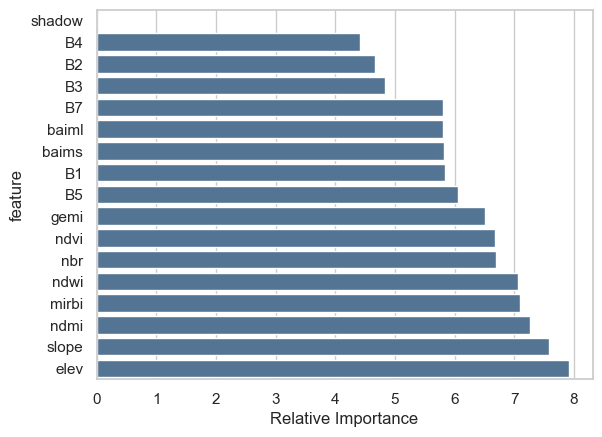

In [84]:
importance = ee.Dictionary(classifier.explain().get('importance'))

vals = importance.getInfo().values()

variables = importance.getInfo().keys()

imp = pd.DataFrame(vals, variables).reset_index().rename(columns = {'index': 'feature', 0: 'value'}).sort_values('value')

## calculating relative importance

imp['rel_imp'] = imp['value']*100/imp['value'].sum()

import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

ax = sns.barplot(data = imp,
           y = 'feature',
           x  = 'rel_imp',
           color = '#49759c')
ax.set(xlabel='Relative Importance')

plt.show()

In [141]:

js_snippet = """ 
}
"""
geemap.js_snippet_to_py(js_snippet)

### split train and test

In [148]:
## classifier

training = image.select(bands).sampleRegions(**{
  'collection' : training_points,
  'properties' : [label],
  'scale': 30
})

In [158]:
##Adds a column of deterministic pseudorandom numbers.
training = training.randomColumn()

split = 0.7

training_points = training.filter(ee.Filter.lt('random', split))
validation_points = training.filter(ee.Filter.gte('random', split))

training_points.first().getInfo()

validation_points.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '11_0',
 'properties': {'B1': 0.151354119181633,
  'B2': 0.16839967668056488,
  'B3': 0.19971393048763275,
  'B4': 0.25785401463508606,
  'B5': 0.3216153085231781,
  'B7': 0.25481507182121277,
  'baiml': 23.14938932152985,
  'baims': 23.161174912698275,
  'class1': 8,
  'mirbi': 1.3963206946849822,
  'nbr': 0.005927688907831907,
  'ndmi': -0.11003394424915314,
  'ndvi': 0.12706327438354492,
  'ndwi': -0.20986172556877136,
  'random': 0.72664157329318}}

In [176]:
classifier = ee.Classifier.smileRandomForest(100).train(training_points, 'class1', bands)

In [177]:
# Classify the image with the same bands used for training.
result = image.select(bands).classify(classifier)

# # Display the clusters with random colors.
Map.addLayer(result.randomVisualizer(), {}, 'classfied')
Map.centerObject(result)
Map

Map(bottom=229801.0, center=[21.86311093593943, 76.7732172877952], controls=(WidgetControl(options=['position'…

In [183]:
validation_points_gdp = geemap.ee_to_geopandas(validation_points)
validation_points_gdp['class1'].value_counts()

11    42
5     14
1      8
2      6
8      4
13     4
4      3
Name: class1, dtype: int64

In [178]:
validated = validation_points.classify(classifier)

In [179]:
test_accuracy= validated.errorMatrix('class1', 'classification')

In [180]:
test_accuracy.accuracy().getInfo()

0.6419753086419753

In [190]:
cf2 = pd.DataFrame(test_accuracy.getInfo())
cf2.loc['Total',:] = cf2.sum(axis=0)
#Total sum per row: 
cf2.loc[:,'Total'] = cf2.sum(axis=1)
cf2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Total
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,8.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0
5,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,14.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,4.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [192]:
cf2= cf2.loc[:,(cf2 != 0).any(axis=0)]
cf2 =cf2.loc[(cf2 != 0).any(axis=1),:]

In [193]:
cf2.reindex(index=cf.index, columns=cf.columns)

Predicted,1,2,4,5,8,10,11,13
Actual,,,,,,,,
1,5.0,0.0,NaN,0.0,0.0,0.0,3.0,0.0
2,0.0,0.0,NaN,4.0,0.0,0.0,1.0,1.0
4,1.0,0.0,NaN,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,NaN,13.0,0.0,0.0,1.0,0.0
8,0.0,0.0,NaN,0.0,2.0,1.0,1.0,0.0
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,1.0,1.0,NaN,7.0,0.0,0.0,32.0,1.0
13,0.0,0.0,NaN,2.0,0.0,0.0,2.0,0.0
